Neighborhood analysis is a powerful approach in spatial biology that explores how cells interact with their local microenvironment. Using Histolytics, users can quantitatively assess the spatial relationships and organizational patterns of cells within tissue sections. Key analyses include:

- **Link counts:**
Count the number of specific cell-cell links (e.g., immune-to-neoplastic) within a defined radius, providing insights into cellular interactions and potential functional relationships.

- **Neighborhood Characteristics:**  
Identify and quantify the summary characteristics of nuclei surrounding a given nuclei, 

- **Neighborhood Distances:**  
Measure distances between nuclei or between a nuclei and its neighbors, enabling the study of spatial proximity.

- **Diversity and Heterogeneity:**  
Calculate neighborhood diversity metrics (e.g., Shannon entropy) to assess the heterogeneity of cell types or cell characteristics within a defined radius, providing insights into tissue complexity and organization.

These analyses help uncover the spatial context of cellular interactions for understanding tissue function, disease progression, and the tumor microenvironment. Histolytics streamlines these workflows.

<Axes: >

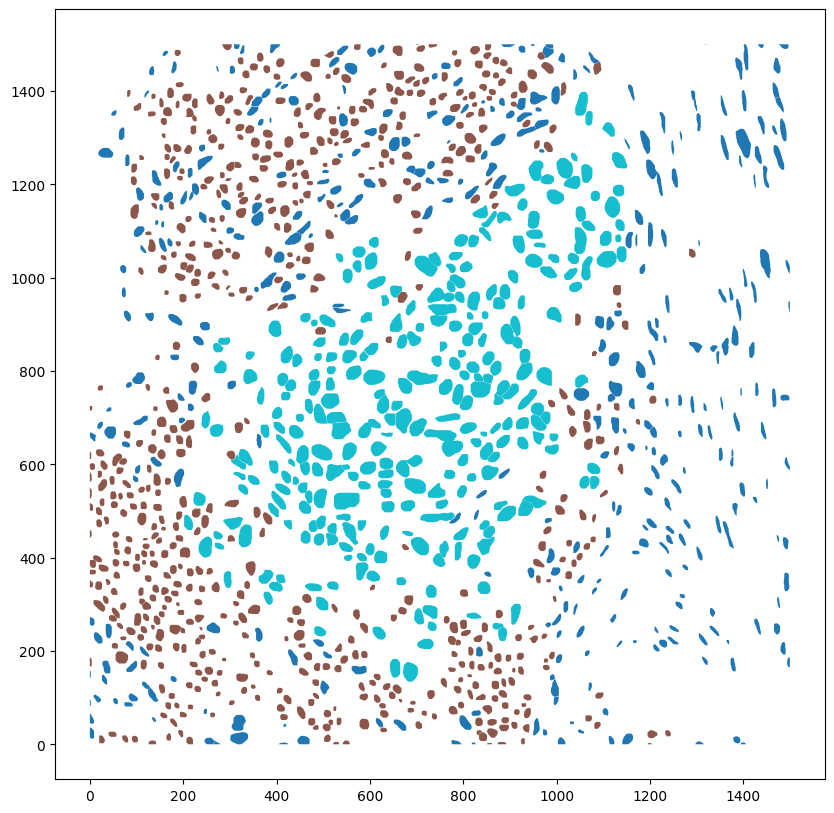

In [1]:
from histolytics.data import hgsc_cancer_nuclei

nuc = hgsc_cancer_nuclei()
nuc.plot(figsize=(10, 10), column="class_name", aspect=1)

## Spatial Weights

First, we need to fit a connectivity graph to the `GeoDataFrame` to get the neighborhoods of the cells (sometimes it is called spatial weights in geospatial analysis jargon). `histolytics` provides a `fit_graph` function which can be used to do that. The actual fitting is done with the `libpysal` package and the `fit_graph`-function is basically a wrapper around different graph fitting methods. The allowed spatial weights are:

- `knn`: k-nearest neighbors
- `delaunay` - Delaunay triangulation
- `distband` - Distance band i.e. a distance thresholded knn graph
- `relative_nhood` - Relative neighborhood graph
- `gabriel` - Gabriel graph
- `voronoi` - Voronoi graph

We will be using the `delaunay` method in this example. Here, we will set a distance threshold for the neighbors to be within 50 microns of the nuclei centroid. The distance unit in the example data is in pixels so 50 microns in pixels of 20x magnified segmentation mask is around 50*2 = 100 pixels.

index  focal  neighbor  weight  focal_centroid_x  focal_centroid_y  \
0      0      0         1     1.0       1400.037980          1.692484   
1      1      0         4     1.0       1400.037980          1.692484   
2      6      1         4     1.0       1386.458579          9.580762   
3      9      2         3     1.0       1378.296689        170.695478   
4     13      2        23     1.0       1378.296689        170.695478   

   neighbor_centroid_x  neighbor_centroid_y focal_class_name  \
0          1386.458579             9.580762       connective   
1          1306.059654             2.527988       connective   
2          1306.059654             2.527988       connective   
3          1318.355274           178.923534       connective   
4          1367.454971           219.690997       connective   

  neighbor_class_name             class_name  \
0          connective  connective-connective   
1          connective  connective-connective   
2          connective  connective-connective   
3          connective  connective-connective   
4          connective  connective-connective   

                                          geometry  
0      LINESTRING (1400.038 1.692, 1386.459 9.581)  
1       LINESTRING (1400.038 1.692, 1306.06 2.528)  
2       LINESTRING (1386.459 9.581, 1306.06 2.528)  
3  LINESTRING (1378.297 170.695, 1318.355 178.924)  
4  LINESTRING (1378.297 170.695, 1367.455 219.691)

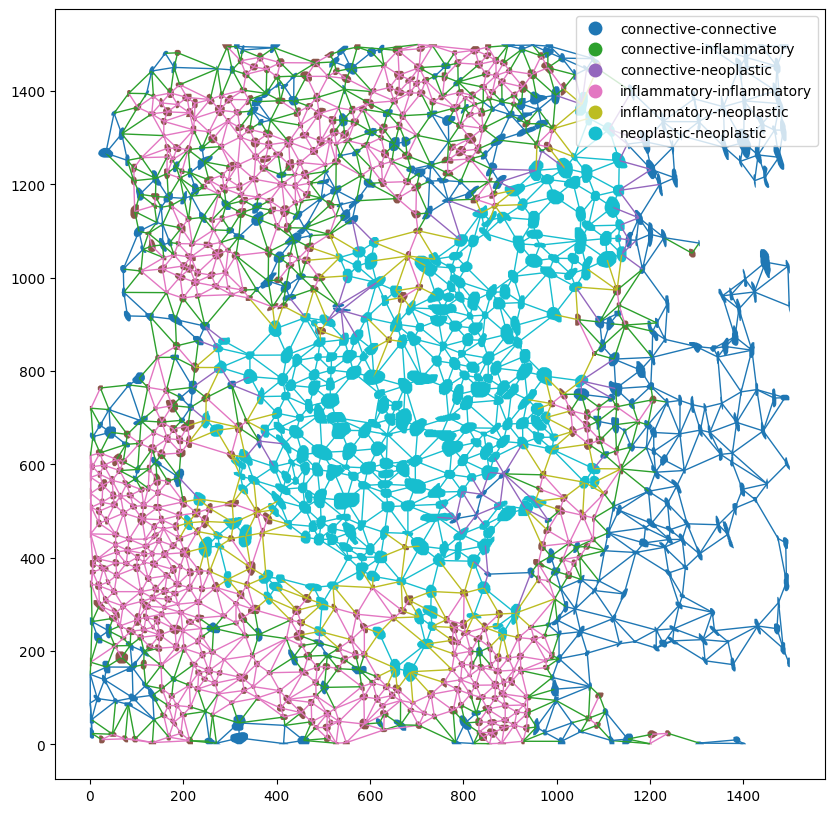

In [2]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.utils.gdf import set_uid

nuc = set_uid(nuc)  # Ensure the GeoDataFrame has a unique identifier
w, w_gdf = fit_graph(nuc, "delaunay", id_col="uid", threshold=100)
ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
w_gdf.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1)
w_gdf.head(5)

## Link counts and custom metrics

In [3]:
# Link counts
w_gdf.value_counts("class_name")

class_name
inflammatory-inflammatory    1347
connective-inflammatory       748
neoplastic-neoplastic         692
connective-connective         582
inflammatory-neoplastic       228
connective-neoplastic          81
Name: count, dtype: int64

Selecting only immune-neoplatic links to see whether there is potential interaction between immune and neoplastic cells.

<Axes: >

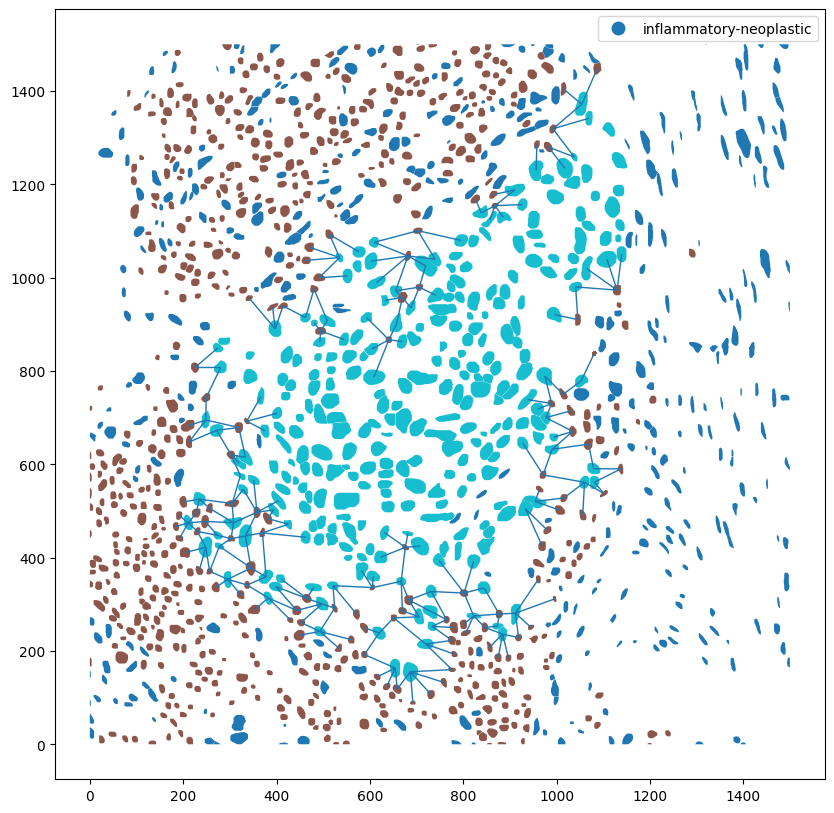

In [4]:
imm_neo_links = w_gdf[w_gdf["class_name"] == "inflammatory-neoplastic"]

ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
imm_neo_links.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1)

 Next, we'll showcase how you can create custom metrics to analyze the spatial relationships. We will define a custom metric to analyze the local immune and stromal context around neoplastic cells. This metric will help us understand how neoplastic cells are surrounded by different cell types, particularly focusing on inflammatory and connective tissue cells.

- **Inflammatory ratio:** For each neoplastic nucleus, we calculate the ratio of inflammatory neighbors to the total number of inflammatory and connective neighbors. This highlights neoplastic cells that are surrounded predominantly by inflammatory cells versus connective cells.

These metrics help quantify and visualize the local immune and stromal context around neoplastic cells, providing insights whether the neoplastic nuclei are physically blocked by the connective nuclei.

geometry  class_name  uid  \
uid                                                                       
292  POLYGON ((651 143.01, 649.01 144.01, 647.01 14...  neoplastic  292   
316  POLYGON ((496 231.01, 492.77 231.94, 489 232.0...  neoplastic  316   
340  POLYGON ((626 224.01, 619 225.01, 617.01 226.0...  neoplastic  340   

                                         nhood_classes  inflammatory_cnt  \
uid                                                                        
292  [neoplastic, inflammatory, inflammatory, infla...                 4   
316  [neoplastic, inflammatory, inflammatory, conne...                 5   
340  [neoplastic, neoplastic, inflammatory, inflamm...                 3   

     connective_cnt  inflammatory_ratio  
uid                                      
292               0            1.000000  
316               1            0.833333  
340               0            1.000000

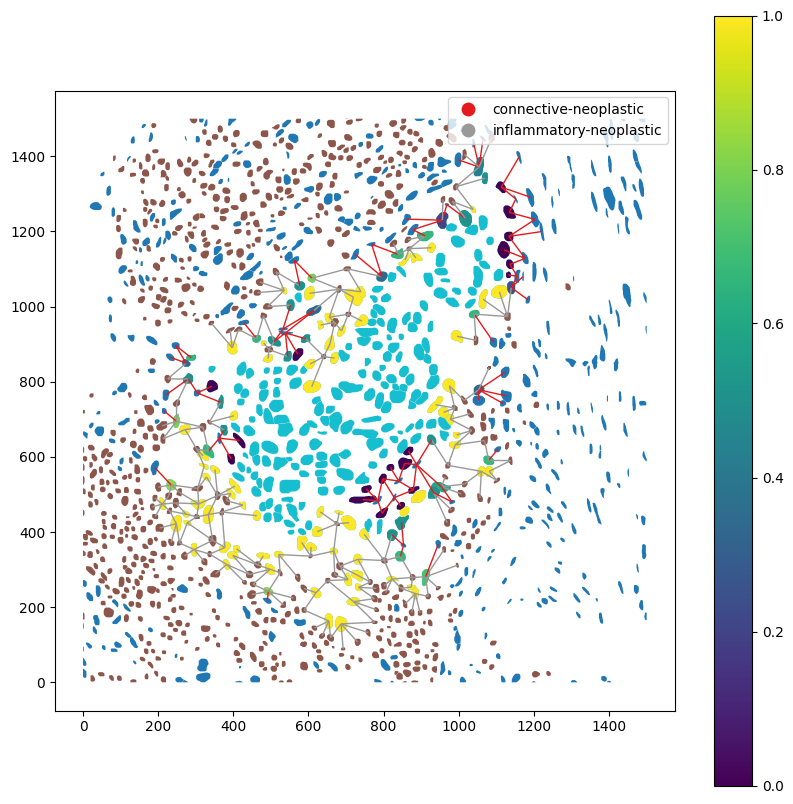

In [5]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from histolytics.spatial_agg.local_values import local_vals


# Custom function to compute the ratio of inflammatory to connective neighbors
def compute_inflammatory_ratio(row):
    if row["inflammatory_cnt"] == 0 and row["connective_cnt"] == 0:
        return 0
    return row["inflammatory_cnt"] / (row["inflammatory_cnt"] + row["connective_cnt"])


def compute_neighbor_cnt(nhood_classes: List[str]) -> Tuple[float, float]:
    inflammatory_count = np.sum(np.array(nhood_classes) == "inflammatory")
    connective_count = np.sum(np.array(nhood_classes) == "connective")
    return inflammatory_count, connective_count


# get the neighborhood classes for each nucleus
nuc = local_vals(
    nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

# Filter for neoplastic nuclei
neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()

# Compute neighborhood inflammatory and connective counts
neo_nuc[["inflammatory_cnt", "connective_cnt"]] = (
    neo_nuc["nhood_classes"].apply(compute_neighbor_cnt).apply(pd.Series)
)

# Compute the ratio of inflammatory to connective neighbors around neoplastic nuclei
neo_nuc["inflammatory_ratio"] = neo_nuc.apply(compute_inflammatory_ratio, axis=1)

# keep only the neoplastic nuclei with inflammatory or connective neighbors
filtered_neo_nuc = neo_nuc[
    (neo_nuc["inflammatory_cnt"] > 0) | (neo_nuc["connective_cnt"] > 0)
]

# Filter the links to only include inflammatory-neoplastic and connective-neoplastic
imm_conn_neo_links = w_gdf[
    w_gdf["class_name"].isin(["inflammatory-neoplastic", "connective-neoplastic"])
]

# Let's visualize the neoplastic nuclei with their inflammatory ratio
ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
filtered_neo_nuc.plot(ax=ax, column="inflammatory_ratio", legend=True, aspect=1)
imm_conn_neo_links.plot(
    ax=ax, linewidth=1, column="class_name", legend=True, aspect=1, cmap="Set1"
)
filtered_neo_nuc.head(3)

In this example, most of the neoplastic nuclei are surrounded by inflammatory nuclei, making them potentially more susceptible to immune responses. Let's now do the same but with bigger data

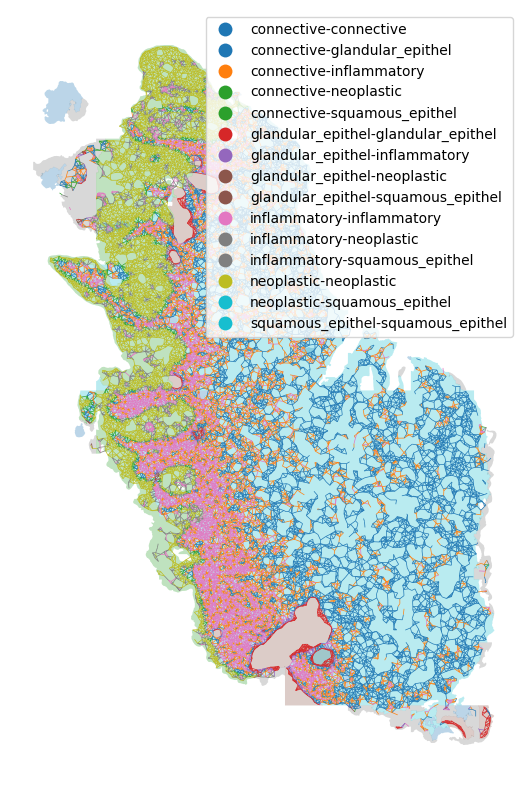

In [6]:
from histolytics.data import cervix_nuclei, cervix_tissue

nuc = cervix_nuclei()
tis = cervix_tissue()  # only for visualization

nuc = set_uid(nuc)  # ensure unique IDs for nuclei
w, w_gdf = fit_graph(nuc, "delaunay", id_col="uid", threshold=100)

# visualize the links on the tissue
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
w_gdf.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1, lw=0.5)
ax.set_axis_off()


Only immune-neoplastic links


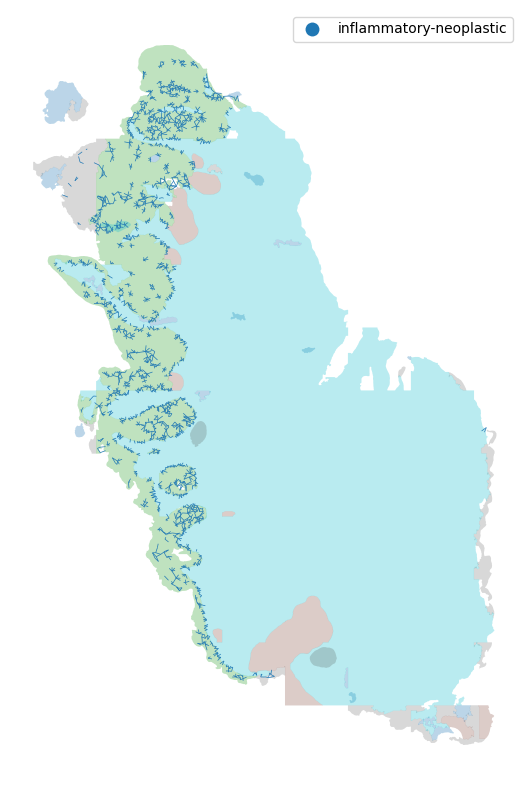

In [7]:
imm_neo_links = w_gdf[w_gdf["class_name"] == "inflammatory-neoplastic"]
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
imm_neo_links.plot(ax=ax, linewidth=0.5, column="class_name", legend=True, aspect=1)
ax.set_axis_off()

In [8]:
w_gdf.value_counts("class_name")

class_name
connective-connective                  15216
connective-inflammatory                12399
inflammatory-inflammatory              11953
neoplastic-neoplastic                   8470
inflammatory-neoplastic                 2526
glandular_epithel-glandular_epithel     1142
connective-neoplastic                    780
glandular_epithel-inflammatory           439
connective-glandular_epithel             382
glandular_epithel-neoplastic              80
connective-squamous_epithel                5
inflammatory-squamous_epithel              2
glandular_epithel-squamous_epithel         1
neoplastic-squamous_epithel                1
squamous_epithel-squamous_epithel          1
Name: count, dtype: int64

<Axes: >

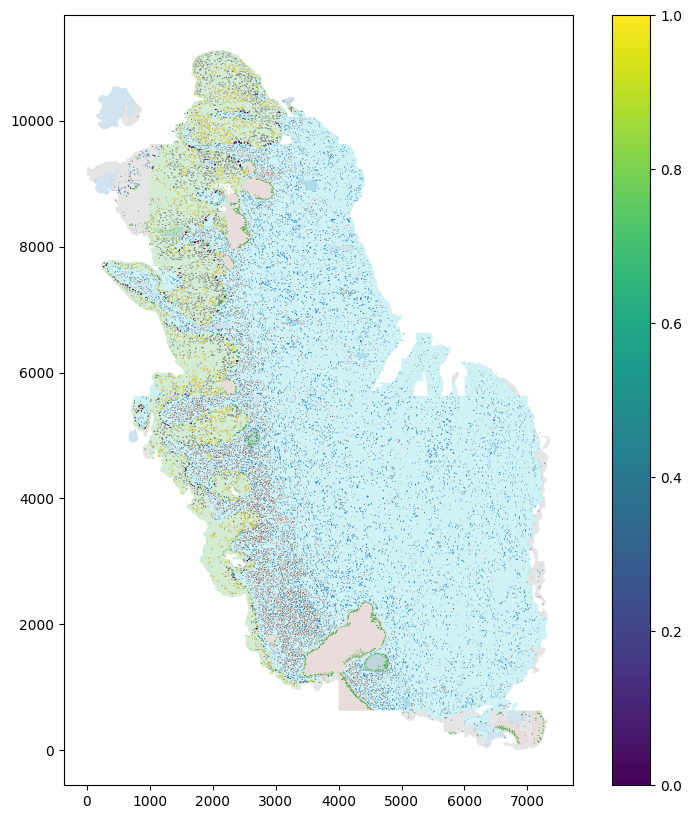

In [9]:
nuc = local_vals(
    nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()
neo_nuc[["inflammatory_cnt", "connective_cnt"]] = (
    neo_nuc["nhood_classes"].apply(compute_neighbor_cnt).apply(pd.Series)
)

neo_nuc["inflammatory_ratio"] = neo_nuc.apply(compute_inflammatory_ratio, axis=1)

filtered_neo_nuc = neo_nuc[
    (neo_nuc["inflammatory_cnt"] > 0) | (neo_nuc["connective_cnt"] > 0)
]
imm_conn_neo_links = w_gdf[
    w_gdf["class_name"].isin(["inflammatory-neoplastic", "connective-neoplastic"])
]

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.2)
ax = nuc.plot(ax=ax, column="class_name", aspect=1)
filtered_neo_nuc.plot(
    ax=ax, column="inflammatory_ratio", legend=True, aspect=1, cmap="viridis"
)

Here we see that the majority of neoplastic nuclei bordering stroma, are surrounded by inflammatory nuclei instead of being blocked by connective cells, indicating an activated immune response.

## Neighborhood Characteristics

The `local_character` function in Histolytics enables the computation of summary statistics (such as mean, median, or standard deviation) for any quantitative feature (e.g., area, eccentricity) within each cell's spatial neighborhood. By aggregating these features across neighbors defined by the spatial graph, users can quantify local microenvironmental characteristics for each cell. Here we will compute the mean area of neighboring nuclei for each neoplastic nucleus, providing insights to regional differences in cell size.

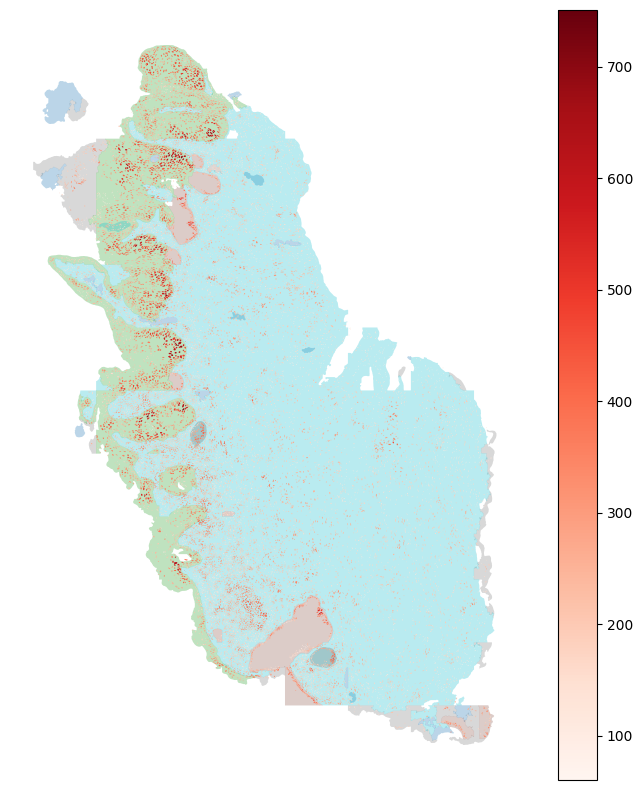

In [10]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.spatial_geom.shape_metrics import shape_metric
from histolytics.spatial_agg.local_character import local_character


# Calculate shape metrics
nuc = shape_metric(nuc, ["area", "eccentricity"])

# Fit delaunay graph
w, _ = fit_graph(nuc, "delaunay", id_col="uid", threshold=100, use_polars=True)

# Compute local neighborhood summaries for shape metrics
nuc = local_character(
    nuc,
    w,
    val_cols=["area", "eccentricity"],
    id_col="uid",
    reductions=["mean"],
    num_processes=6,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="area_nhood_mean", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

The more red, the larger the mean area of the neighbors. Here we see that the neoplastic nuclei around the basal layer are surrounded by larger nuclei, which is commonly expected. The immune dense regions of the stroma are surrounded by smaller nuclei, which is also expected as the immune cells are generally smaller than neoplastic cells.

## Neighborhood Distances

The `local_distances` function in Histolytics allows users to measure distances between a cell and its neighbors, or between pairs of cells, providing insights into cell packing density, spatial organization, and potential interactions.

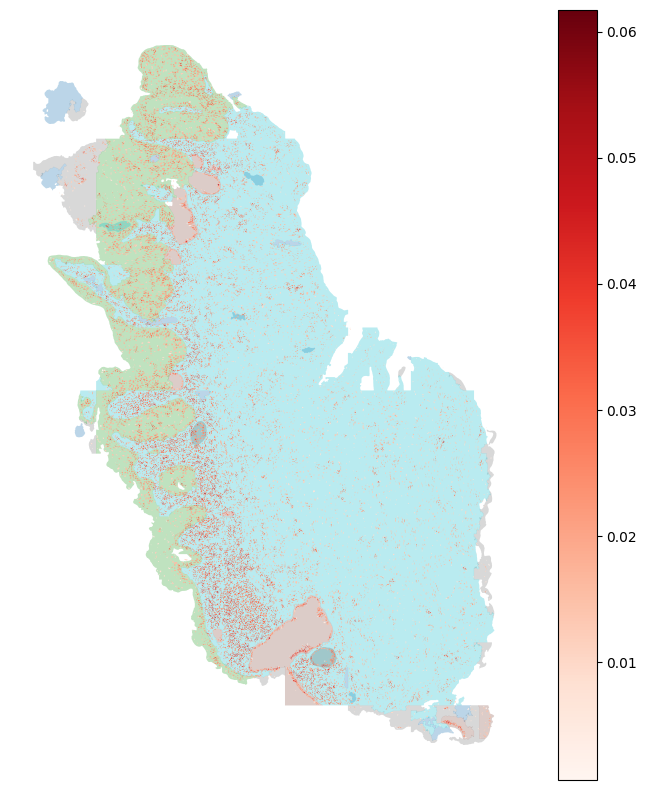

In [11]:
from histolytics.spatial_agg.local_dists import local_distances

# Compute local neighborhood distances
nuc = local_distances(
    nuc,
    w,
    id_col="uid",
    reductions=["median"],
    num_processes=6,
    invert=True,  # invert distances for visualizing densely packed nuclei nhoods
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="nhood_dists_median", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

The more red, the smaller the mean distance to the neighbors (more densely packed). We see that the neoplastic nuclei around the basal layer are more densely packed than the neoplastic nuclei in the superficial layers. Also, the we see that the stroma contains densely packed regions mostly consisting of immune cells, which is indicative of immune response.

## Neighborhood Diversity and Heterogeneity

The `local_diversity` function in Histolytics calculates diversity metrics (e.g., Shannon entropy) for the cell neighborhoods, quantifying the heterogeneity of cell types or characteristics within a defined radius. This analysis helps assess tissue complexity and organization. The diversity indices can be computed either on categorical or continuous features. When the feature is continuous, the diversity is computed by binning the values into categories.

Supprted diversity indices include:  
- `shannon_index` - Shannon entropy
- `simpson_index` - Simpson's diversity index
- `gini_index` - Gini coefficient
- `theil_index` - Theil index


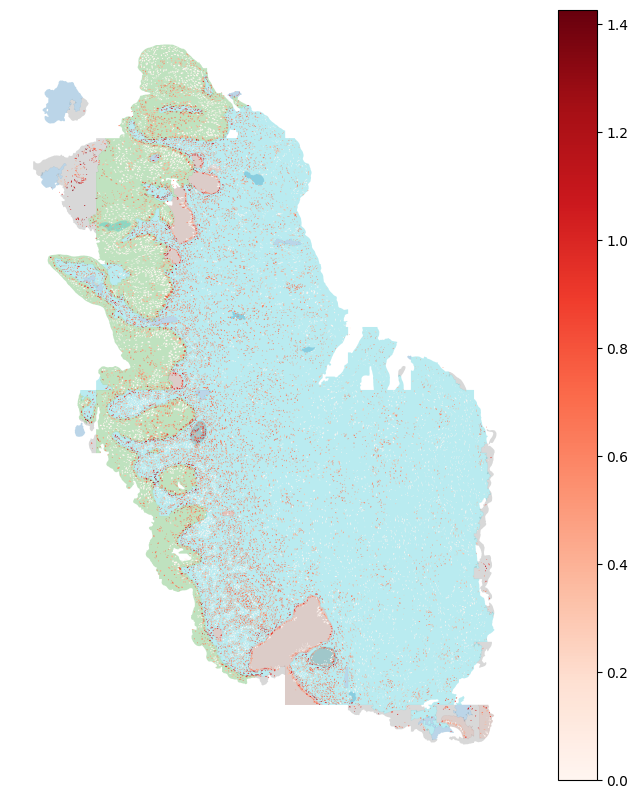

In [12]:
from histolytics.spatial_agg.local_diversity import local_diversity

# Compute local cell type diversity with shannon entropy
nuc = local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["class_name"],
    metrics=["shannon_index"],
    num_processes=6,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(
    ax=ax, column="class_name_shannon_index", aspect=1, cmap="Reds", legend=True
)
ax.set_axis_off()

As expected, the diversity is higher around tissue borders where the stroma meets other tissues.
Next we will compute the diversity of a contiguous variable. We will use the area of the neighbors. The more red, the higher the diversity of the area of the neighbors.

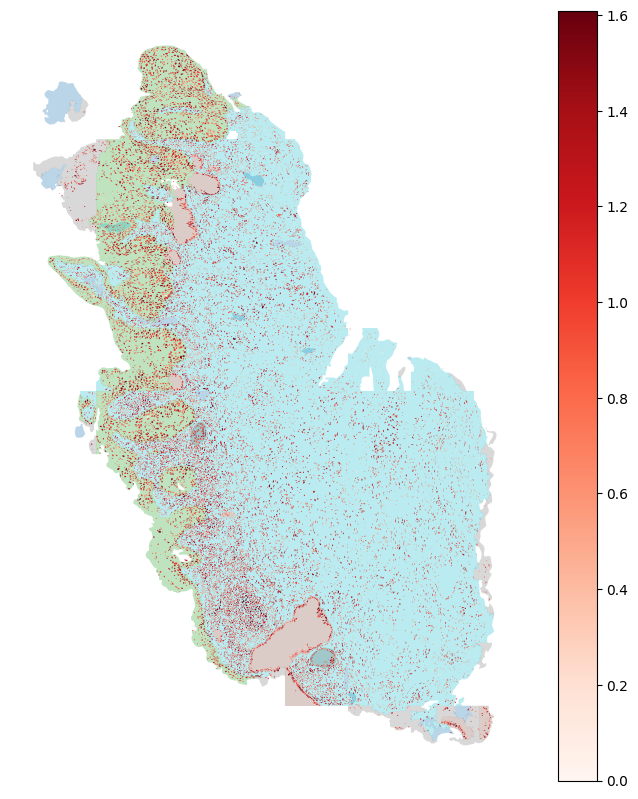

In [13]:
# Compute local cell type diversity with shannon entropy
# We will use fisher-jenks classification to bin the contiguous values for entropy
nuc = local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["area"],
    metrics=["shannon_index"],
    num_processes=6,
    scheme="fisherjenks",
    k=5,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="area_shannon_index", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

This concludes how to analyze spatial cell neighborhoods using Histolytics, including link counts, neighborhood characteristics, distances, and diversity metrics. These methods quantify local cell interactions and microenvironmental features, and can be flexibly applied to any computed categorical or continuous variable for in-depth tissue analysis. 